In [2]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian
from scipy.optimize import curve_fit

In [45]:
from IPython.display import HTML, display
from plotly.offline import init_notebook_mode

init_notebook_mode()
display(
    HTML(
        '<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.2.2/es5/tex-mml-svg.min.js" integrity="sha512-4MXl9OmsJPCU3LySQiKq4baSCSNFha8CBJL7NVSmN+WJJNLhJUycJgGdxJlxAY2ih8jhP9juGYq2ThUihYBKIw==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>'  # noqa: E501
    )
)

In [3]:
import plotly.io as pio

pio.renderers.default = "png"

In [4]:
colors = px.colors.qualitative.Plotly

In [5]:
g = (np.sqrt(5) + 5) / 8
h = (np.sqrt(5) + 1) / 4
J = 1

In [6]:
def compute_expt(L, op):
    basis = spin_basis_1d(L=L, kblock=0, pblock=+1)

    with open(f"data/eig/L={L}/L={L}_k=0_p=+1.npy", "rb") as f:
        energies = np.load(f)
        eigenstates = np.load(f)

    # basis = spin_basis_1d(L=L, kblock=1)

    # with open(f"data/eig/L={L}/L={L}_k=1.npy", "rb") as f:
    #     energies = np.load(f)
    #     eigenstates = np.load(f)

    sx = hamiltonian([op], [], basis=basis)

    sx_expt = sx.expt_value(eigenstates, enforce_pure=True).real / L

    return energies / L, sx_expt

In [ ]:
L = (14, 16, 18)
# L = (13, 15, 17)

results = [compute_expt(l, ["xx", [[1, i, (i + 1) % l] for i in range(l)]]) for l in L]

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


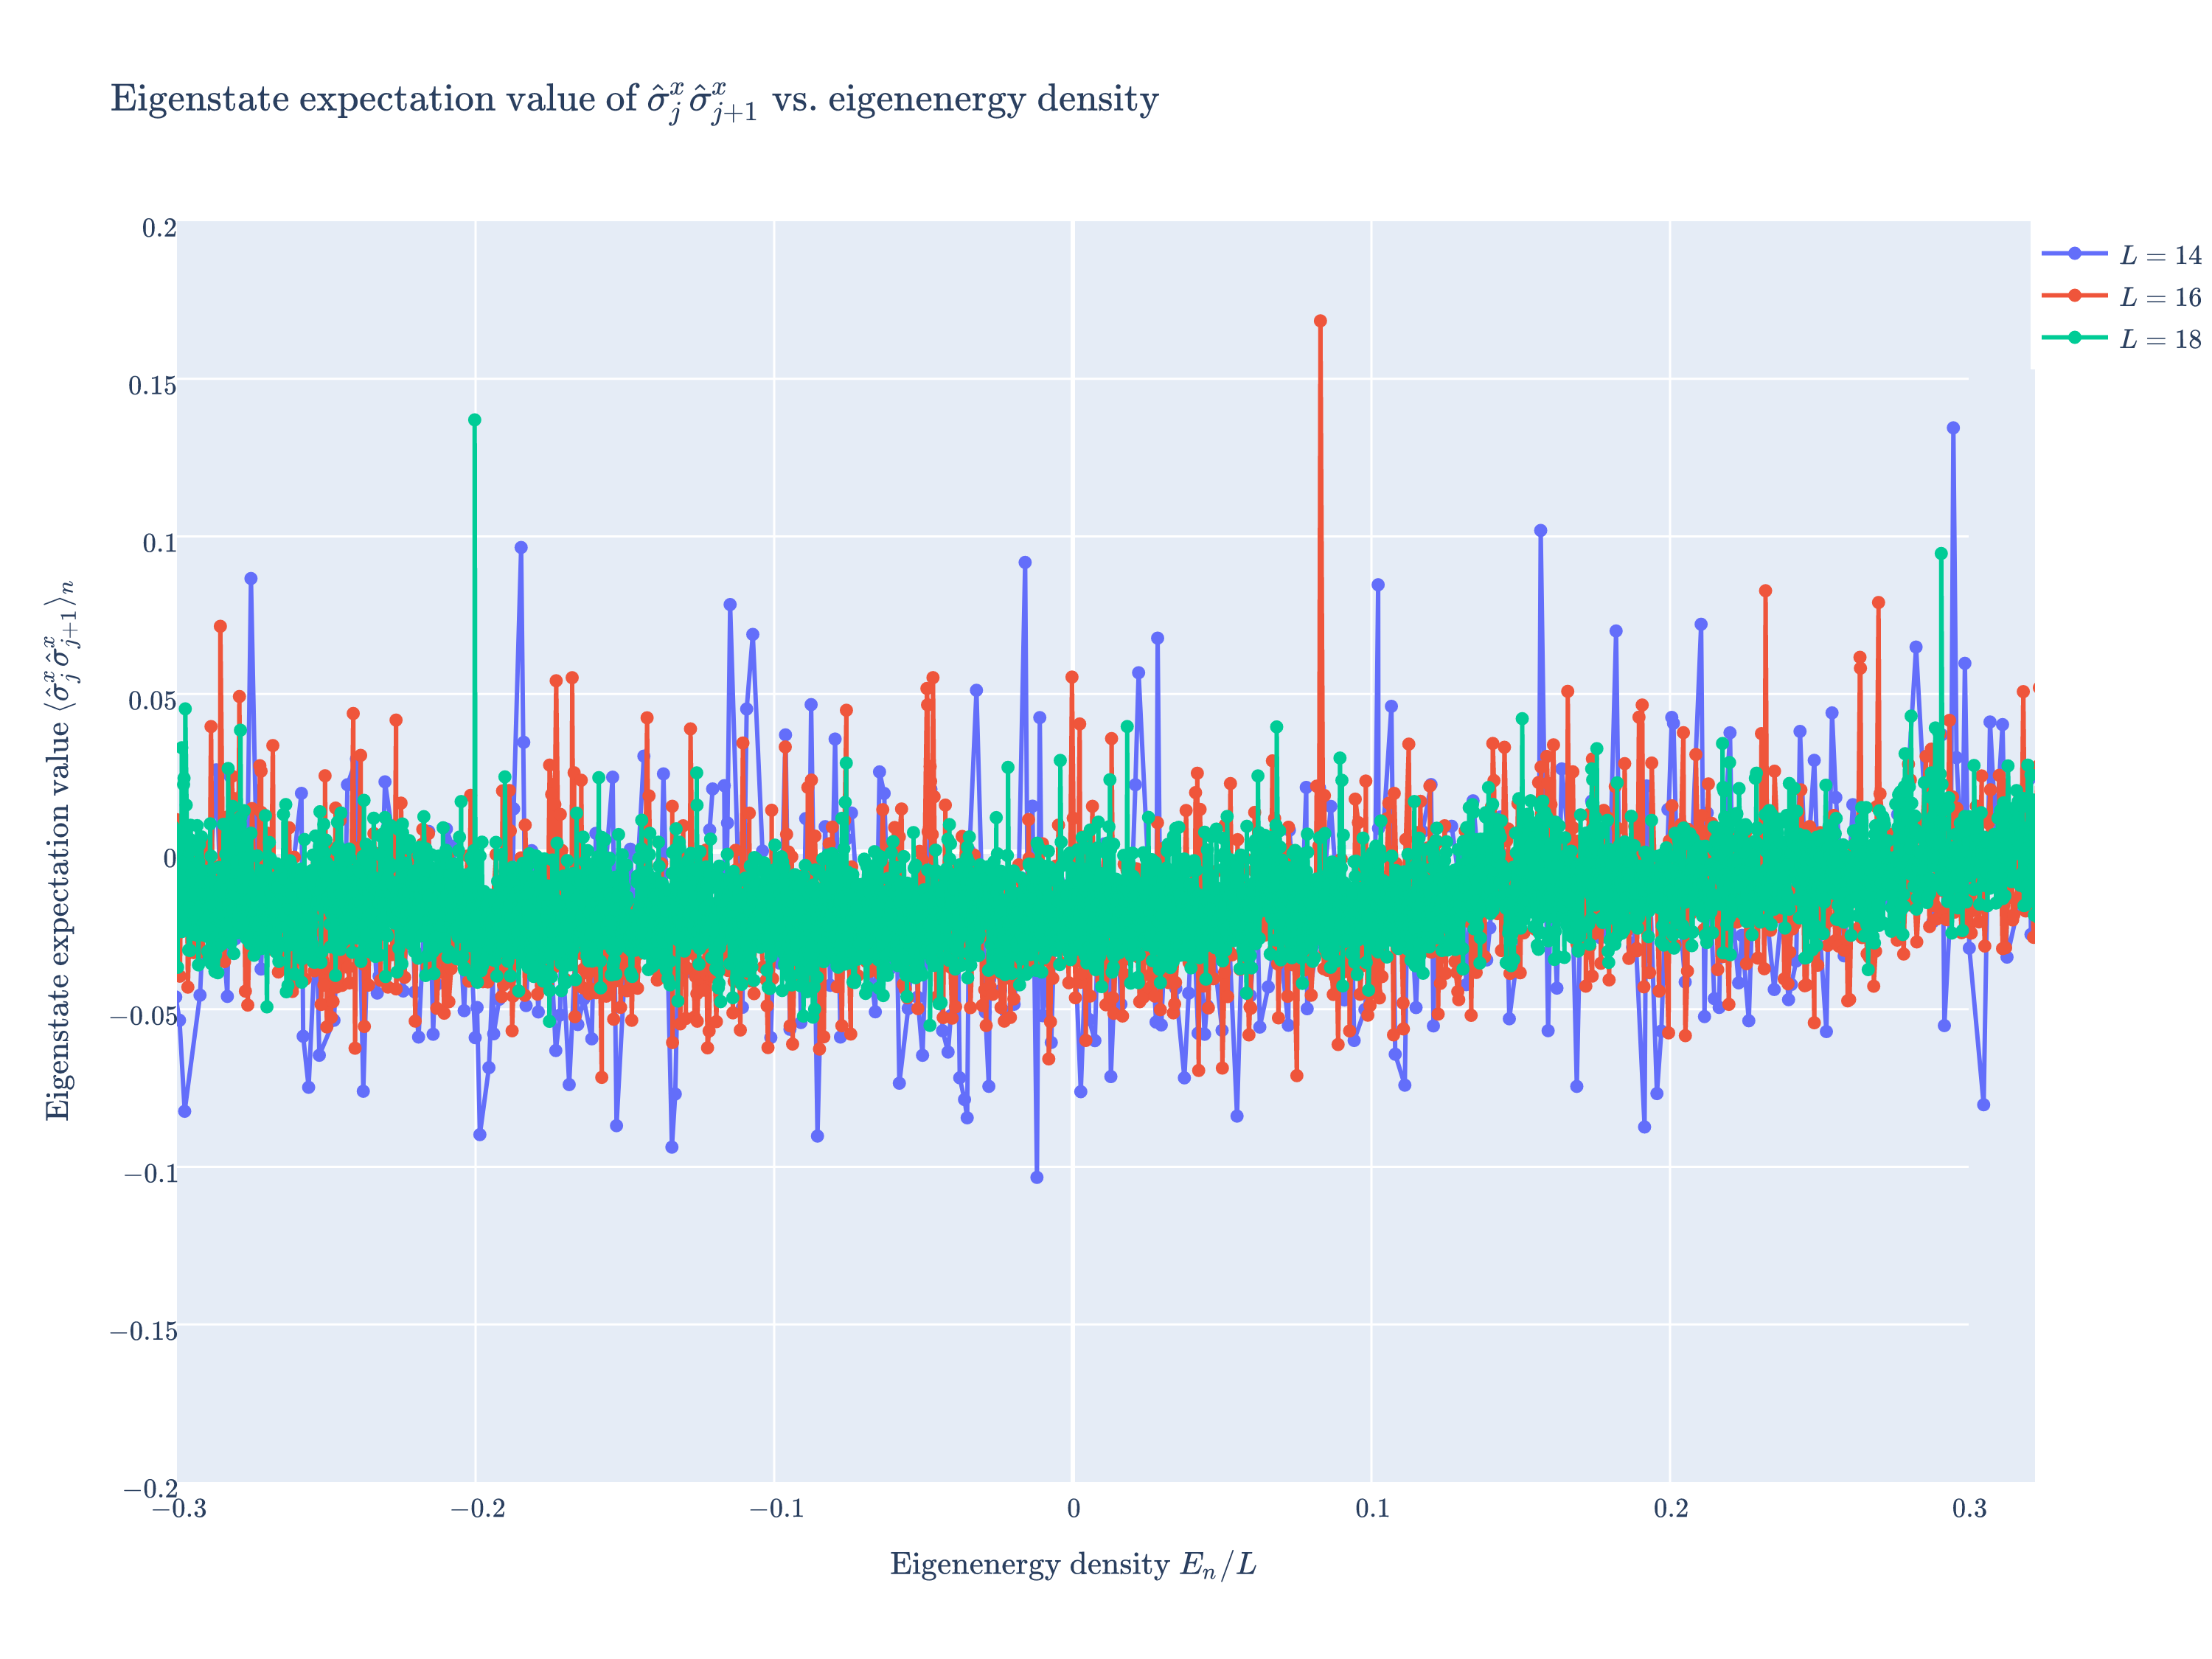

In [9]:
figure = go.Figure(
    data=[
        go.Scatter(
            x=energy_densities,
            y=expt,
            mode="markers+lines",
            line_color=colors[i],
            name=f"$L={l}$",
        )
        for i, (l, (energy_densities, expt)) in enumerate(zip(L, results))
    ]
)

figure.update_layout(
    width=1000,
    height=750,
    xaxis=dict(
        title=r"$\text{Eigenenergy density }E_n/L$",
        range=[-0.3, 0.3],
        tickprefix="$",
        ticksuffix="$",
    ),
    yaxis=dict(
        title=r"$\text{Eigenstate expectation value }\langle\hat{\sigma}^x_j\hat{\sigma}^x_{j+1}\rangle_n$",
        range=[-0.2, 0.2],
        tickprefix="$",
        ticksuffix="$",
    ),
    title=r"$\text{Eigenstate expectation value of }\hat{\sigma}^x_j\hat{\sigma}^x_{j+1}\text{ vs. eigenenergy density}$",
)

figure.show(scale=3)

In [10]:
def gaussian(x, A, sigma):
    return A * np.exp(-(x**2) / (2 * sigma**2))

In [11]:
L = [14, 15, 16, 17, 18]

In [12]:
def compute_hist(L, op):
    _, expt = compute_expt(L, op)
    diff_abs = np.abs(np.diff(expt))
    P, bin_edges = np.histogram(diff_abs, bins="auto", density=True)
    r = (bin_edges[:-1] + bin_edges[1:]) / 2

    popt, pcov = curve_fit(gaussian, r, P, bounds=[(0, 0), (100, 1)])

    return r, P, popt, pcov, diff_abs

In [ ]:
results = [compute_hist(l, ["xx", [[1, i, (i + 1) % l] for i in range(l)]]) for l in L]

sigmas = np.array([result[2][1] for result in results])
sigma_errs = np.array([np.sqrt(np.diag(result[3])[1]) for result in results])

diff_abs_avg = np.array(
    [np.sqrt(np.mean(result[4] ** 2) - np.mean(result[4]) ** 2) for result in results]
)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


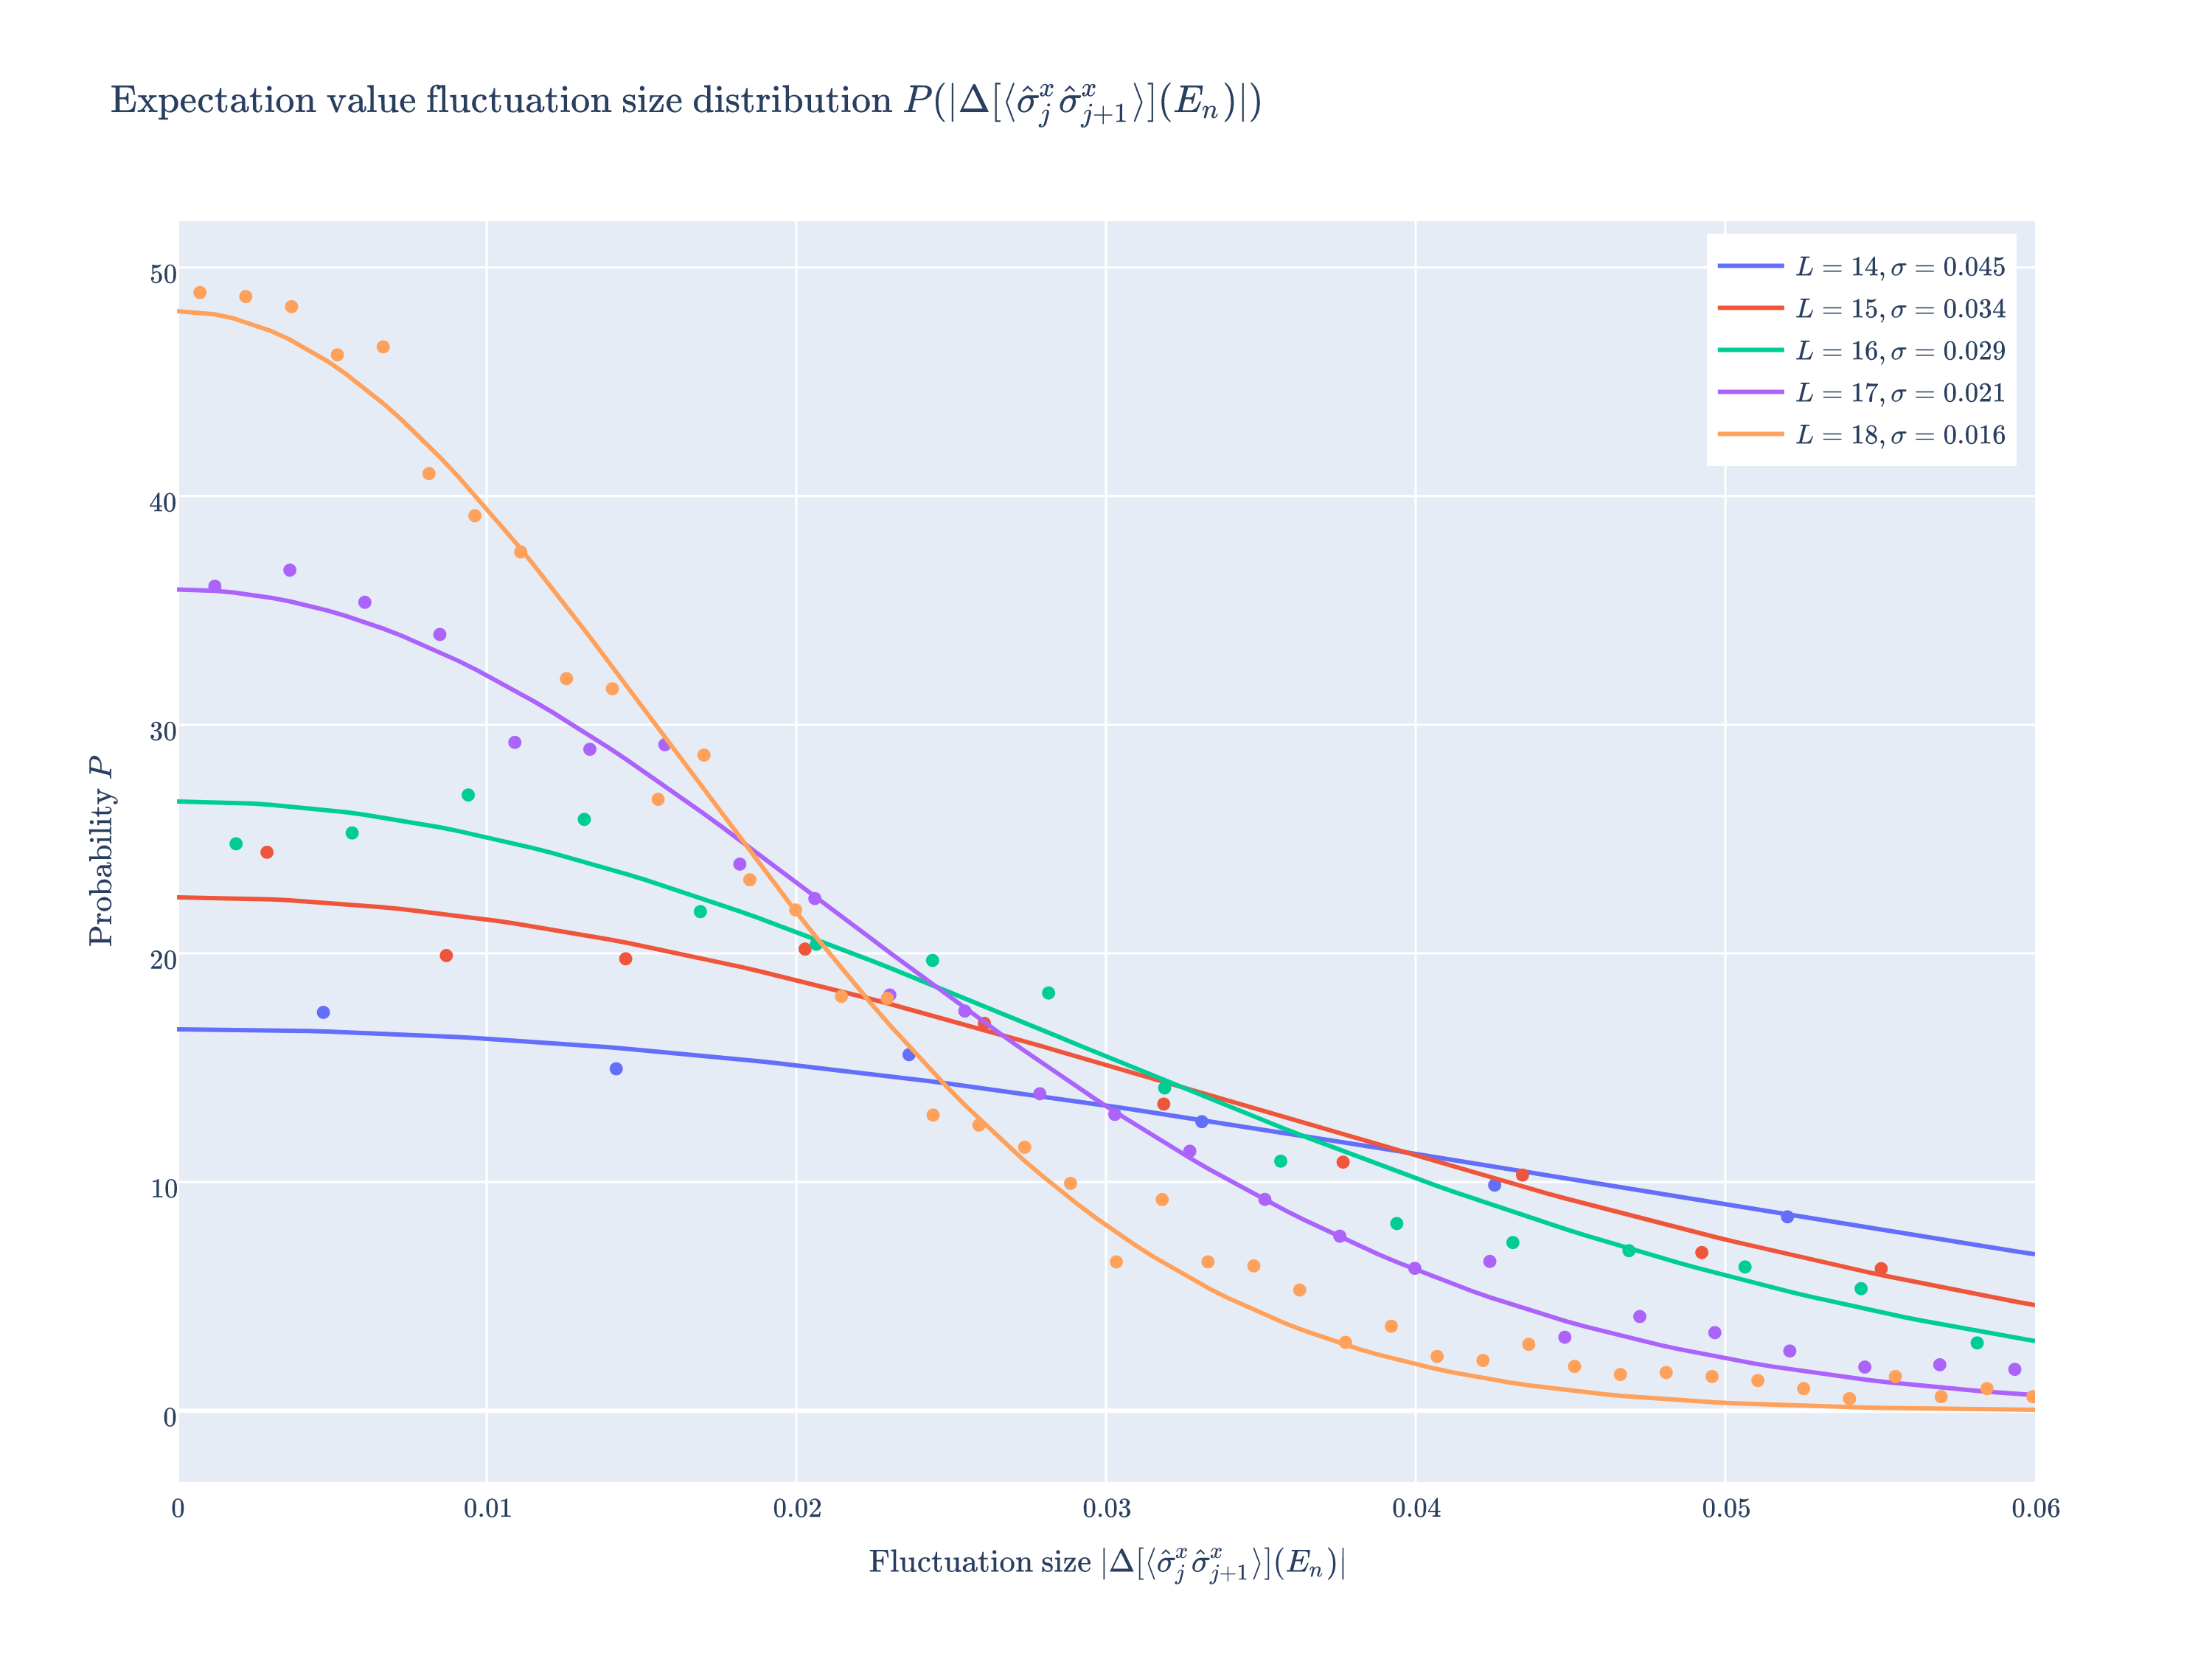

In [14]:
figure = go.Figure()

for l, (r, P, popt, _, _), color in zip(L, results, colors):
    figure.add_trace(
        go.Scatter(x=r, y=P, showlegend=False, mode="markers", line_color=color)
    )
    figure.add_trace(
        go.Scatter(
            x=np.linspace(0, 0.06, 100),
            y=gaussian(np.linspace(0, 0.06, 100), *popt),
            name=rf"$L={l},\sigma={popt[1]:.3f}$",
            line_color=color,
        )
    )

figure.update_layout(
    width=1000,
    height=750,
    title=r"$\text{Expectation value fluctuation size distribution }P(|\Delta[\langle \hat{\sigma}^x_j\hat{\sigma}^x_{j+1} \rangle ](E_{n})|)$",
    xaxis=dict(
        title=r"$\text{Fluctuation size }|\Delta[\langle \hat{\sigma}^x_j\hat{\sigma}^x_{j+1} \rangle ](E_{n})|$",
        range=[0, 0.06],
        tickprefix="$",
        ticksuffix="$",
    ),
    yaxis=dict(
        title=r"$\text{Probability }P$",
        tickprefix="$",
        ticksuffix="$",
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
    ),
)

figure.show(scale=3)

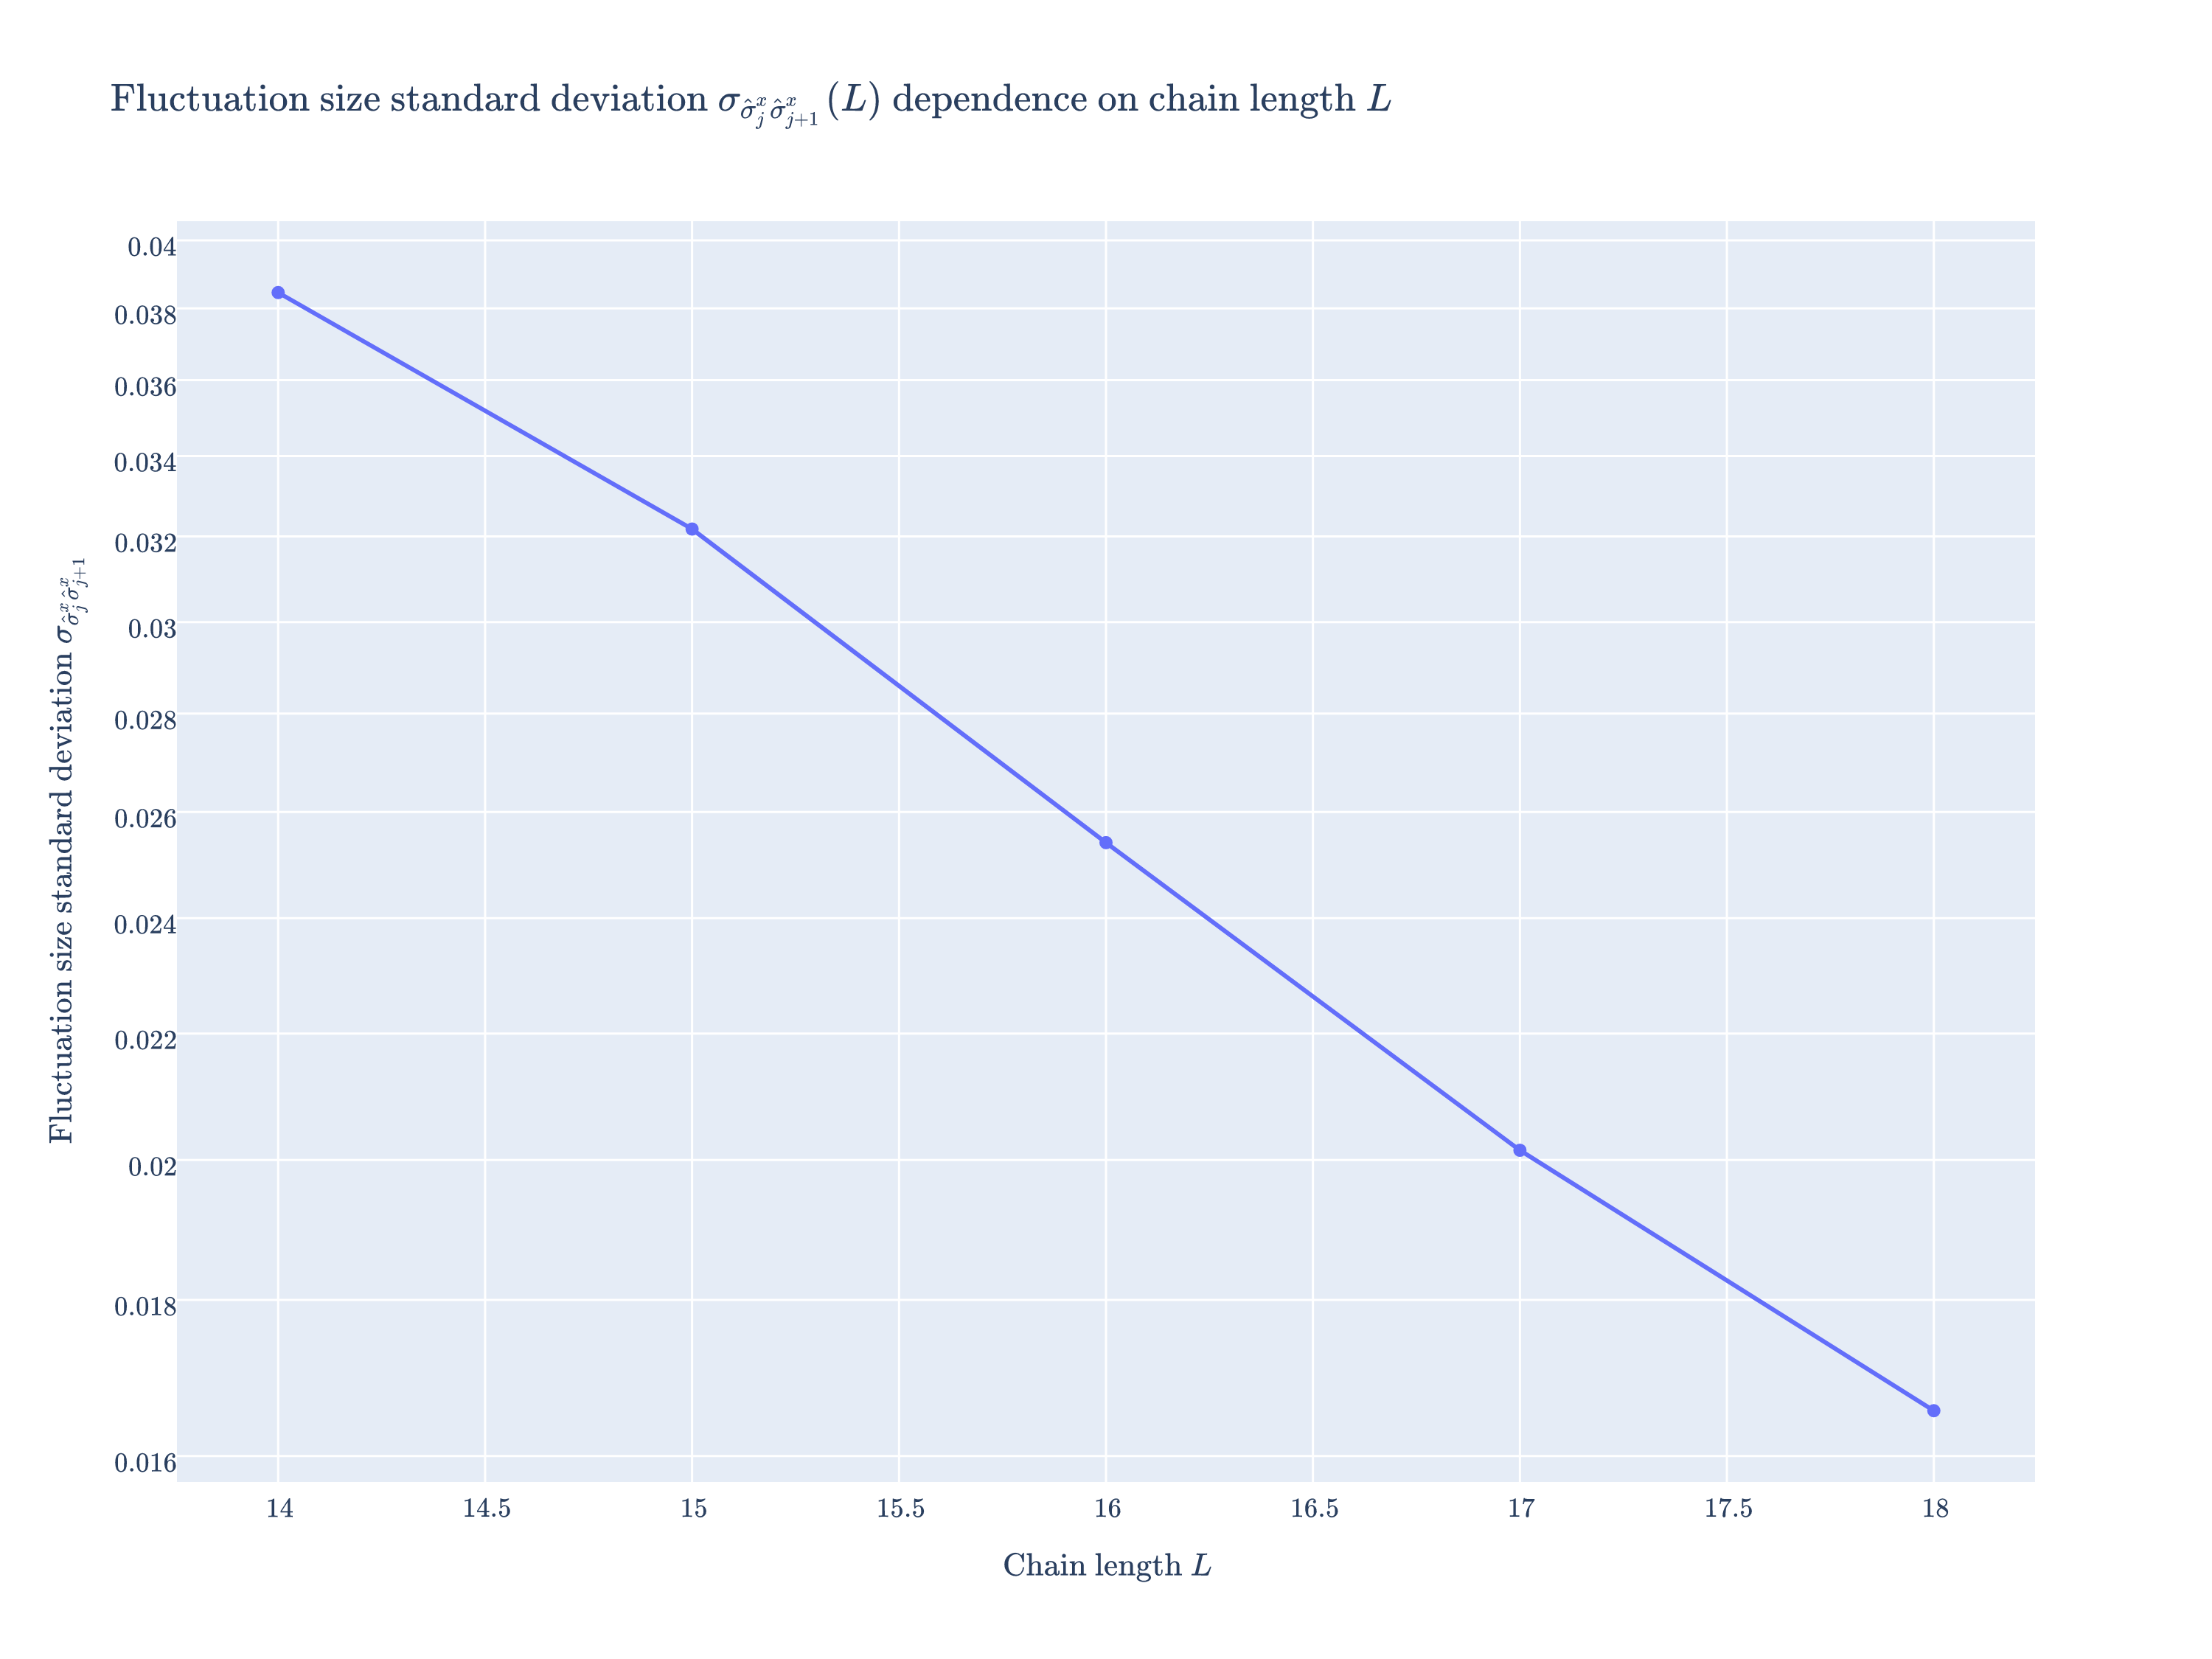

In [15]:
figure = go.Figure(
    data=[
        go.Scatter(x=L, y=diff_abs_avg),
    ]
)

figure.update_layout(
    width=1000,
    height=750,
    title=r"$\text{Fluctuation size standard deviation }\sigma_{\hat{\sigma}^x_j\hat{\sigma}^x_{j+1}}(L)\text{ dependence on chain length }L$",
    xaxis=dict(
        title=r"$\text{Chain length }L$",
        tickprefix="$",
        ticksuffix="$",
    ),
    yaxis=dict(
        title=r"$\text{Fluctuation size standard deviation }\sigma_{\hat{\sigma}^x_j\hat{\sigma}^x_{j+1}}$",
        tickprefix="$",
        ticksuffix="$",
        type="log",
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
    ),
)

figure.show(scale=3)